In [101]:
import numpy as np
import pandas as pd

from __future__ import division, print_function
from matplotlib import pyplot as plt
#from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import pandas as pd
import numpy as np

%matplotlib inline
#import seaborn as sns
#sns.set(color_codes=True)
pd.set_option('display.max_columns', 50)

import matplotlib
matplotlib.style.use('default')
matplotlib.rc('figure', figsize = (7, 4))

#### `Useful functions =====>`

In [102]:
###############################################
# Histogram plot

def histogram(data, x_label, y_label, title):
    #names = ["6-9", "9-12", "12-15", "15-18", "18-21", "21-24", "24-27", "27-30", "30-33", "33-36", "36-39", "39-42", "42-45"]
    _, ax = plt.subplots()
    ax.hist(data, color = '#539caf', align='mid', bins=[3*j for j in range(16)], rwidth=0.95)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.xaxis.set_major_locator(MultipleLocator(3))
    #ax.set_xticklabels(names,rotation=45)
    ax.set_title(title)

    
    
###############################################
# Calculates the rise in daily city temperature
# from 2003 to 2017
# Rise in city temperature from 2003-2017 = Avg. city temperature from 2015 to 2017 - Avg. city temperature from 2003 to 2005

# Output : [--------------1d-Array representing the avg temp rise in different cities---------------->]

def get_temp_rise(data, cities):
    initial_years = np.arange(2003, 2006)
    final_years = np.arange(2015, 2018)
    
    initial_temp = {}
    final_temp = {}
    
    for city in cities:
        initial_temp[city] = []
        final_temp[city] = []
        
    L = []
    
    for year in initial_years:
        dt = data.copy()
        keysList = dt.keys()
        city_str = TIME + str(year)[2:]
        to_drop = [ky for ky in keysList if (ky[0:len(city_str)] != city_str)]
        dt.drop(columns=to_drop, inplace=True)
        for city in cities:
            initial_temp[city].extend(dt.loc[city].dropna())
                    
    mni = {}
            
    for year in final_years:
        dt = data.copy()
        keysList = dt.keys()
        city_str = TIME + str(year)[2:]
        to_drop = [ky for ky in keysList if (ky[0:len(city_str)] != city_str)]
        dt.drop(columns=to_drop, inplace=True)
        for city in cities:
            if (len(dt.loc[city].dropna()) == 0):
                continue
            final_temp[city].extend(dt.loc[city].dropna())
            
    for i, city in enumerate(cities):
        mni[city] = (np.mean(final_temp[city]) - np.mean(initial_temp[city])).round(2)
    print(mni)
    return mni

#### `Main Code =====>`

In [103]:
#######################################################################################################

def ee_estimate(data):

    new_names =  {'Unnamed: 0': 'ID'}
    data.rename(columns=new_names, inplace=True)
    cities = data['city_nm'].dropna().tolist()

    data = data.set_index('city_nm') # set index column
    data_copy = data.copy()

    column_names = data_copy.columns

    city_str = TIME + str(year)[2:] 
    to_drop = [ky for ky in column_names if (ky[0:len(city_str)] != city_str) and (ky != 'ID')]
    data_copy.drop(columns=to_drop, inplace=True) # Retain only those columns whose column name starts with "Day03...."


    # Each key [0-289] represents a city
    temperature2003 = {}
    temperature2017 = {}


    for city in cities:
        temperature2003[city] = ((data_copy.loc[city].dropna()[1:] - 273.15).round(2)).tolist()


    """
    temperature2003 =
                        {
                        0: [------------ array (Daily temperature of the 0-th city)],
                        1: [------------ array (Daily temperature of the 1-th city)],
                        .
                        .
                        .
                        189: [------------ array (Daily temperature of the 189-th city)],
                        }

    """    


    temp_rise = get_temp_rise(data, cities)

    """
    temp_rise =
                {
                0: number (avg temperature rise for the 0-th city),
                1: number (avg temperature rise for the 1-th city),
                .
                .
                .
                189: number (avg temperature rise for the 189-th city),
                }

    """

    for i, city in enumerate(cities):
        temperature2017[city] = (temperature2003[city] + temp_rise[city]).round(2) # Assuming each day became hotter by the annual average amount

    hist2003 = {}
    hist2017 = {}
    ee = {}


    """
    hist2003 = 
                {
                0: [------------ array (temperature histogram of the 0-th city)],
                1: [------------ array (temperature histogram of the 1-th city)],
                .
                .
                .
                189: [------------ array (temperature histogram of the 189-th city)],
                }


    coeffs = [------------array(energy demand increase coefficients for individual histogram bars-------)]

    """

    coeffs = [0., 0., 0., 0.0305, 0.0167, 0.000991, -0.00506, 0, 0.0314, 0.0679, 0.111, 0.149, 0., 0., 0.]

    # Taken from table 3 of the Santosh paper (pan india coefficients)

    # The coefficients of the temperature bins can then be interpreted as percentage changes in 
    # demand with an additional day in temperature bin j, relative to a reference temperature bin.

    """
    ee = 
        {
        0: number (increase in energy demand for 0-th city),
        1: number (increase in energy demand for 1-th city),
        .
        .
        .
        189: number (increase in energy demand for 189-th city),
        }

    """



    for ky in temperature2003.keys():
        hist2003[ky], _ = np.histogram(temperature2003[ky], bins=[3*j for j in range(16)])
        hist2017[ky], _ = np.histogram(temperature2017[ky], bins=[3*j for j in range(16)])

        ee[ky] = (np.sum(coeffs * (hist2017[ky] - hist2003[ky]))).round(2)
        
    return (cities, ee, temperature2003, temperature2017)

In [128]:
year = 2003
TIME = 'Night'

data = pd.read_csv("rural.daily.df17.csv")
#print(data['city_nm'])
#print(list(data.columns))
#new_names =  {'Unnamed: 0': 'ID'}
#data.rename(columns=new_names, inplace=True)
#cities = data['city_nm'].dropna().tolist()

#data = data.set_index('city_nm')

#city_str = 'Night06'
#to_drop = [ky for ky in column_names if (ky[0:len(city_str)] != city_str) and (ky != 'ID')]
#data.drop(columns=to_drop, inplace=True)
#print(data.loc['Makum'])


(cities, buffer_ee, temperature2003, temperature2017) = ee_estimate(data)

{'BENAULIM': 0.11, 'JAFARABAD': 1.26, 'MANGLAUR': 1.25, 'NYORIAHUSAINPUR': 1.48, 'AVANASHI': 1.03, 'Kaladi': 0.26, 'TIRUCHENGODU': 0.88, 'MONGRA': 0.57, 'TONSEWEST': 0.07, 'BUDHNI': 0.28, 'REMUNA': 0.84, 'ANNAMALAINAGAR': 0.69, 'PASTHAL': 0.19, 'KOMALAPURAM': nan, 'BANAT': 1.24, 'HUSSAINPUR': nan, 'Jasidih': 0.87, 'OLDMALDAH': 0.77, 'SUKET': 0.78, 'CHARIBATIA': 0.2, 'Vallabh Vidhyanagar': 0.58, 'AVINISSERY': 0.33, 'BAGHPAT': 1.45, 'CHICHOLI': 0.93, 'Unchasiwana': 1.08, 'Makum': nan, 'DERACOLLIERYTOWNSHIP': 0.56, 'SWAMIMALAI': 0.94, 'Abrama': 0.31, 'Aurangabad': 1.12, 'TIRUVALLUR': 0.69, 'Deesa': 0.79, 'SUMERPUR': 1.04, 'Rabupura': 1.2, 'INAMKARUR': 1.04, 'KOTHAPALLIHAVELI': 0.6, 'Padra': 0.34, 'Jalalpore': 0.34, 'NELLIKUPPAM': 0.74, 'GONIANA': nan, 'GOKUL': 1.31, 'CHARTHAVAL': 1.38, 'RAVALGAON': 0.06, 'JHUSI': 1.37, 'ATHIMARAPATTI': nan, 'UTTARBAGDOGRA': 1.14, 'KASHIPUR': 1.84, 'Chaya': 0.58, 'Babugarh': 1.04, 'KASIMBAZAR': 0.91, 'Bawal': 1.34, 'Dinapur\xc2\xa0Cantonment': 0.51, 'SANKA

np.save('energy_demand.npy', ee)
np.save('temperature_rise.npy', temp_rise)
np.save('temperature2003.npy', temperature2003)
np.save('temperature2017.npy', temperature2017)

#### `Example =====>`

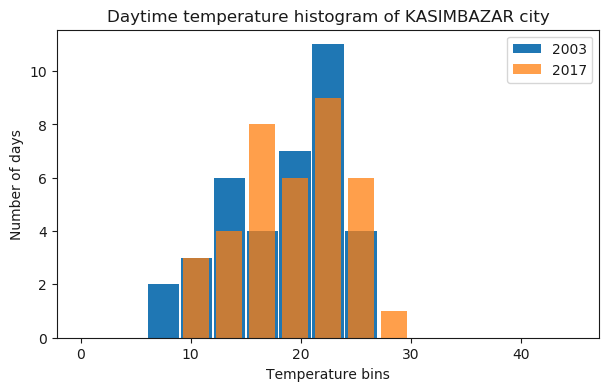

In [129]:
city_idx = 30

_, ax = plt.subplots()
#ax.set_facecolor((1.0, 1.0, 1.0))
#ax.spines['bottom'].set_color('#000000')
#ax.spines['top'].set_color('#000000') 
#ax.spines['right'].set_color('#000000')
#ax.spines['left'].set_color('#000000')
#ax.axes.get_xaxis().set_visible(True) 
#ax.axes.get_yaxis().set_visible(True) 
#ax.tick_params(axis='x', colors='#000000')
#ax.tick_params(axis='y', colors='#000000')
#ax.yaxis.set_ticks(np.arange(0, 12, 2))
#ax.xaxis.set_ticks(np.arange(0, 46, 3))
ax.hist(temperature2003[cities[city_idx]], align='mid', alpha=1, bins=[3*j for j in range(16)], rwidth=0.95, label='2003')
ax.hist(temperature2017[cities[city_idx]], align='mid', alpha=0.75, bins=[3*j for j in range(16)], rwidth=0.8, label='2017')
ax.set_ylabel('Number of days')
ax.set_xlabel('Temperature bins')
ax.set_title("Daytime temperature histogram of " + str(cities[city_idx]) + " city")
ax.legend(loc='best')


In [138]:
def ee_time_evolution(data):
    coeffs = [0., 0., 0., 0.0305, 0.0167, 0.000991, -0.00506, 0, 0.0314, 0.0679, 0.111, 0.149, 0., 0., 0.]
    
    new_names =  {'Unnamed: 0': 'ID'}
    data.rename(columns=new_names, inplace=True)
    cities = data['city_nm'].dropna().tolist()
    #print(list(data.columns))

    data = data.set_index('city_nm') # set index column
    years = np.arange(2003, 2018)
    years = np.delete(years, 3)
    hist = {}
    ee_evol = {}
    for year in years:
        hist[year] = {}
        data_copy = data.copy()
        column_names = data_copy.columns
        city_str = TIME + str(year)[2:]
        to_drop = [ky for ky in column_names if (ky[0:len(city_str)] != city_str)]
        data_copy.drop(columns=to_drop, inplace=True) # Retain only those columns whose column name starts with "Day03...."
        #print(data_copy.tail())
        #print(list(data_copy.columns))
        #print(year)
        for city in cities:
            
            #print(city)
            hist[year][city] = []
            temperature = ((data_copy.loc[city].dropna() - 273.15).round(2)).tolist()
            hist[year][city], _ = np.histogram(temperature, bins=[3*j for j in range(16)])
            #print(temperature)
    ee = {}
    for i in range(len(years) - 1):
        ee[years[i+1]] = {}
        for city in cities:
            ee[years[i+1]][city] = (np.sum(coeffs * (hist[years[i+1]][city] - hist[years[0]][city]))).round(2)
            
    return ee

In [139]:
data = pd.read_csv("UHI17.csv")
ee = ee_time_evolution(data)

np.save('ee_city.npy', ee)

data_buffer = pd.read_csv("rural.daily.df17.csv")
ee_buffer = ee_time_evolution(data_buffer)

np.save('ee_buffer.npy', ee_buffer)

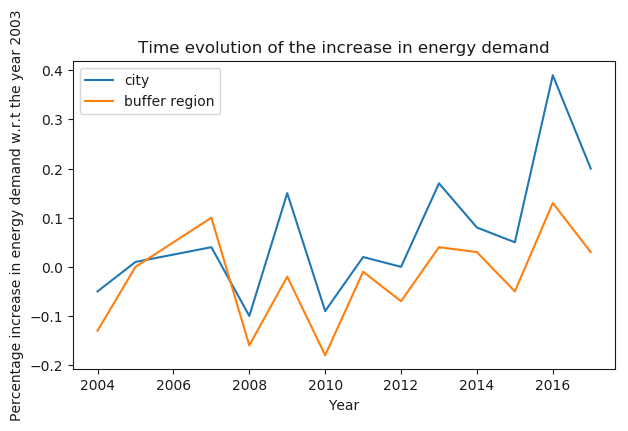

In [142]:
city_idx = 16

years = np.arange(2003, 2018)
years = np.delete(years, 3)
evol = [0]*(len(years)-1)
evol_buffer = [0]*(len(years)-1)

for i in range(len(years) - 1):
    evol[i] = ee[years[i+1]][cities[city_idx]]
    evol_buffer[i] = ee_buffer[years[i+1]][cities[city_idx]]
    
plt.plot(years[1:], evol, label="city")
plt.plot(years[1:], evol_buffer, label="buffer region")
plt.title('Time evolution of the increase in energy demand')
plt.xlabel('Year')
plt.ylabel('Percentage increase in energy demand w.r.t the year 2003')
plt.legend(loc='best')
plt.show()

In [97]:
data = pd.read_csv("UHI17.csv")
data.sample(10)

Unnamed: 0   id  geomtry  cty_pnt    u_men_lt  u_min_lt  u_mx_lt  \
85           85  103      316        1  144.111111       143      146   
98           98  118      356        2   99.210526        93      105   
48           48   61      215        1  216.400000       215      219   
251         251  341      871        1   17.111111         8       34   
189         189  245      658        1  247.666667       242      254   
173         173  227      610        1   45.733333        35       59   
237         237  319      817        1  119.300000       111      134   
107         107  128      379        1   77.000000        76       79   
66           66   82      259        1  315.000000       313      317   
147         147  186      520        1  295.800000       284      303   

     r_mn_lt  r_mx_lt  alt_d__  alt___2        NTL   LU__201 state    distrct  \
85       140    144.0        6     -1.0  57.876082  0.594595   NaN        NaN   
98        91    104.0       14    -11.0  65.234903  0.581227   NaN        NaN   
48       214    218.0        5     -3.0  41.600844  0.578125   NaN        NaN   
251       -8     94.0       42    -86.0  43.825371  0.241135   Goa  South Goa   
189      240    272.0       14    -30.0  38.638970  0.041667   NaN        NaN   
173       28     83.0       31    -48.0  53.689571  0.487685   NaN        NaN   
237       99    155.0       35    -44.0  52.521831  0.680000   NaN        NaN   
107       73     79.0        6     -3.0  41.117438  0.913043   NaN        NaN   
66       300    328.0       17    -15.0  37.912933  0.384615   NaN        NaN   
147      242    329.0       61    -45.0  37.298321  0.232877   NaN        NaN   

    stat_nm      name   city_nm type   ES00POP   ES95POP   ES90POP  Pop  \
85      NaN       NaN       NaN  NaN  109828.0   97505.0   86565.0  NaN   
98      NaN       NaN       NaN  NaN   94819.5   83513.5   72841.0  NaN   
48      NaN       NaN       NaN  NaN   73944.0   65627.0   58246.0  NaN   
251     GOA  BENAULIM  BENAULIM   CT   76427.0   67314.0   58712.0  NaN   
189     NaN       NaN       NaN  NaN       NaN       NaN       NaN  NaN   
173     NaN       NaN       NaN  NaN  114502.0  100849.0   87961.0  NaN   
237     NaN       NaN       NaN  NaN  154059.0  135690.0  118350.0  NaN   
107     NaN       NaN       NaN  NaN  101773.0   90366.0   80237.0  NaN   
66      NaN       NaN       NaN  NaN   36139.0   31229.0   26987.0  NaN   
147     NaN       NaN       NaN  NaN   96097.0   84639.0   73822.0  NaN   

     Night03001.  Night03009.      ...        UHI.Day17169.  UHI.Day17177.  \
85    280.704800   278.070526      ...             0.624915            NaN   
98    281.948286   277.397391      ...             1.078966       0.115239   
48    279.660000   276.331667      ...             3.301412            NaN   
251   294.899429          NaN      ...             0.648970            NaN   
189   285.418462   283.383077      ...            -2.511146            NaN   
173   285.136327   285.308163      ...            -1.955054      -0.906623   
237   291.436571   283.136216      ...                  NaN            NaN   
107   282.906667   279.195556      ...             1.063761       0.569796   
66    276.247143   274.124286      ...            -1.069935      -1.422080   
147   282.002105   278.126316      ...                  NaN            NaN   

     UHI.Day17185.  UHI.Day17193.  UHI.Day17201.  UHI.Day17209.  \
85             NaN            NaN       3.053158            NaN   
98             NaN       1.092412            NaN      -4.181250   
48        1.432311            NaN            NaN            NaN   
251      -2.428571      -5.824145       1.785414       0.867052   
189            NaN            NaN            NaN      -0.715000   
173      -0.699285            NaN            NaN      -1.202377   
237            NaN            NaN      -0.563011       2.122000   
107            NaN            NaN            NaN            NaN   
66        0.139833   

In [140]:
ee

{2004: {'ANNAMALAINAGAR': -0.29,
  'ATHIMARAPATTI': 0.0,
  'AVANASHI': 0.03,
  'AVINISSERY': 0.08,
  'AZHIKODESOUTH': 0.04,
  'Abrama': -0.12,
  'Aurangabad': 0.05,
  'BAGHPAT': -0.05,
  'BANAT': -0.07,
  'BENAULIM': -0.01,
  'BUDHNI': 0.0,
  'Babugarh': -0.21,
  'Bawal': -0.16,
  'CHARIBATIA': -0.15,
  'CHARTHAVAL': 0.0,
  'CHICHOLI': 0.04,
  'Chaya': -0.08,
  'DAROHA': 0.0,
  'DERACOLLIERYTOWNSHIP': 0.2,
  'DEWA': -0.08,
  'DHANAULI': -0.1,
  'Deesa': -0.0,
  'Dinapur\xc2\xa0Cantonment': -0.27,
  'GOKUL': -0.05,
  'GONIANA': 0.0,
  'HUPARI': 0.08,
  'HUSSAINPUR': 0.0,
  'INAMKARUR': -0.13,
  'JAFARABAD': -0.19,
  'JAYSINGPUR': 0.02,
  'JHUSI': 0.02,
  'Jalalpore': -0.05,
  'Jasidih': -0.13,
  'KAKORI': 0.02,
  'KASHIPUR': 0.16,
  'KASIMBAZAR': 0.04,
  'KOMALAPURAM': 0.0,
  'KOTHAPALLIHAVELI': -0.0,
  'KOVVUR': 0.15,
  'Kaladi': -0.03,
  'MANGLAUR': -0.0,
  'MONGRA': -0.11,
  'MONOHARPUR': 0.1,
  'Makum': 0.0,
  'NELLIKUPPAM': -0.13,
  'NYORIAHUSAINPUR': -0.08,
  'OLDMALDAH': -0.19,
 